<a href="https://colab.research.google.com/github/Wappik/Duma_SMPR_kNN/blob/main/Duma_SMPR_kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Метод k ближайших соседей (kNN)**

---

Один из наиболее простых метрических алгоритмов классификации. Работает cледующим образом: дан классифицируемый объект z и обучающая выборка . Требуется определить класс объекта z на основе данных из обучающей выборки. Для этого:

1.   Вся выборка  сортируется по возрастанию расстояния от объекта z до каждого объекта выборки.
2.   Проверяются классы k ближайших соседей объекта z. Класс, встречаемый наиболее часто среди k соседей, присваивается объекту z.

Исходными данными для алгоритма являются: классифицируемый объект, обучающая выборка и параметр k - число рассматриваемых ближайших соседей. Результатом работы метода является класс классифицируемого объекта.

Для проверки оптимальности k используется Критерий Скользящего Контроля ***LOO (Leave One Out)***. Данный критерий проверяет оптимальность значения k следующим образом:

1.   Из обучающей выборки удаляется i-й объект.
2.   Запоминаем "старый" класс i-го объекта.
3.   Запускаем алгоритм для оставшейся выборки. В результате работы i-му элементу присваивается "новый" класс на основе имеющейся выборки. Если значения "нового" и "старого" класса совпали, то i-ый элемент классифицировало верно. При их же несовпадении сумма ошибки увеличивается на 1.
4.   Шаги 1-3 повторяются для каждого объекта выборки при фиксированном k. По окончании работы алгоритма полученная сумма ошибки sum делится на размер выборки l: 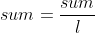  . Потом значение k меняется, и алгоритм повторяется для нового значения. k с наименьшим значением суммы ошибки будет оптимальным.



---
### ***Реализация kNN***
---


При реализации алгоритма, в качестве обучающей выборки использовалась выборка ирисов Фишера. В качестве признаков объектов использовались значения длины и ширины лепестка. Значение k подбиралось по LOO.

Алгоритм:

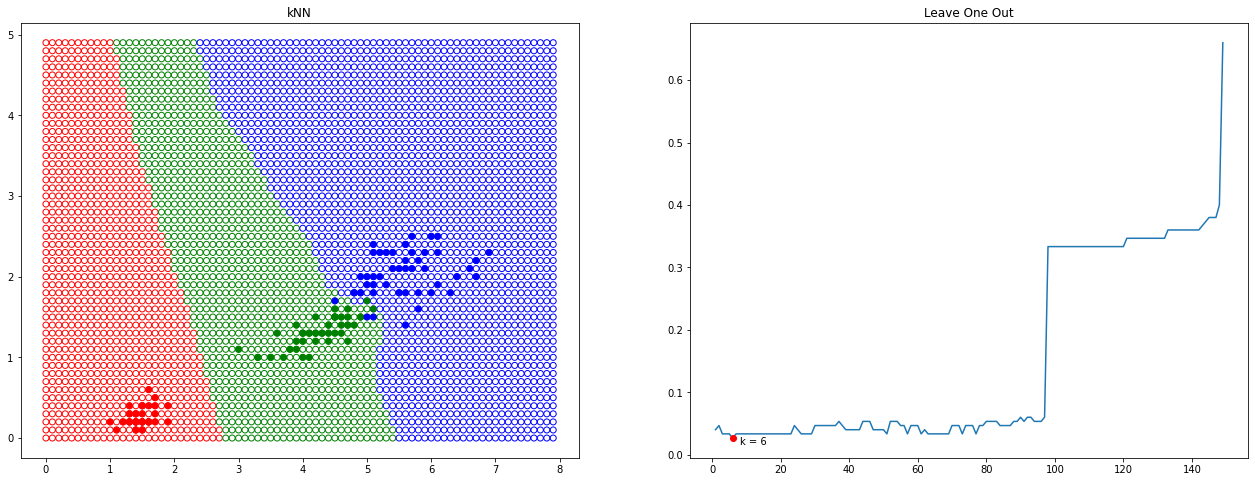

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets


def euclide(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** (0.5)

def sortObjectByDistKnn(point, data, target, k):
    k = int(k)
    distances = []
    for d in data:
        distances.append(euclide(point, d))
    res = list(zip(distances, target))
    sorted_by_distances = sorted(res, key=lambda dist: dist[0])
    classes = [0, 0, 0]
    for i in range(k):
        classes[sorted_by_distances[i][1]] += 1
    max = classes[0]
    maxIndex = 0
    for i in range(3):
        if max < classes[i]:
            max = classes[i]
            maxIndex = i
    return maxIndex

def LOOKnn(data, target):
    sumErrors = []
    for k in range(1, 150):
        errors = []
        for i in range(150):
            error = 0
            dataCopy = list(data)
            objectData = dataCopy[i]
            dataCopy.pop(i)

            if sortObjectByDistKnn(objectData, dataCopy, target, k) != target[i]:
                error += 1
            errors.append(error)
        sumErrors.append((sum(errors) - 1) / 150)
        errors.clear()
    return sumErrors

def drawPointsKnn(point, data, target, targetPoint, errors, k):
    cl = np.array(['red', 'green', 'blue'])
    fig = plt.figure(figsize=(22, 8))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    n_neighbors = np.array(range(1, len(errors) + 1))
    k = k + 1

    ax_1.set(title='kNN')
    ax_1.scatter(point[:, 0], point[:, 1], edgecolors=cl[targetPoint], facecolors='none')
    ax_1.scatter(data[:, 0], data[:, 1], color=cl[target])

    ax_2.set(title='Leave One Out')
    ax_2.scatter(k, errors[k - 1], color='red', zorder=1)
    ax_2.text(k + 2, errors[k - 1] - 0.01, f"k = {k}", fontsize=10)
    ax_2.plot(n_neighbors, errors, zorder=0)

    plt.show()

def genPointKnn(data, target, k):
    k = int(k)
    point = []
    tr = []
    for i in range(80):
        v = i * 0.1
        for j in range(50):
            t = j * 0.1
            classPoint = sortObjectByDistKnn(np.array([v, t]), data, target, k)
            point.append([v, t])
            tr.append(classPoint)
    return np.array(point), np.array(tr)

if __name__ == '__main__':
    iris = datasets.load_iris()
    data = iris.data[:, -2:]
    tr = iris.target
    errorsLOO = LOOKnn(data, tr)
    k = errorsLOO.index(min(errorsLOO))
    point, targetPoint = genPointKnn(data, tr, k)
    drawPointsKnn(point, data, tr, targetPoint, errorsLOO, k)

Достоинства алгоритма:


1.   Простота реализации (относительно)
2.   Хорошее качество, при правильно подобранной метрике и параметре k

Недостатки алгоритма:



1.   Необходимость хранить выборку целиком, как следствие - неэффективное использование памяти
2.   Малый набор параметров
3.   Качество классификации сильно зависит от выбранной метрики
4.   "Выбросы" могут значительно ухудшить точность


---

# **Метод k взвешенных ближайших соседей (kwNN)**

---

Метод kwNN отличается от kNN тем, что вес ближайших соседей зависит не от ранга соседа, а от расстояния до объекта z. В методе kNN считается, что вес каждого k-соседа равен 1. По сути, мы считали частоту появления классов среди ближайших k соседей. Применяя же метод kwNN в качестве весовой функции мы используем w = q^i, что соответствует методу k экспоненциально взвешенных ближайших соседей. Предполагается, что q принадлежит [0.05; 0.95] и рассматриваем с шагом 0.05. Значение k рассматривали в диопазоне [1; 40].

---
### ***Реализация kwNN***
---


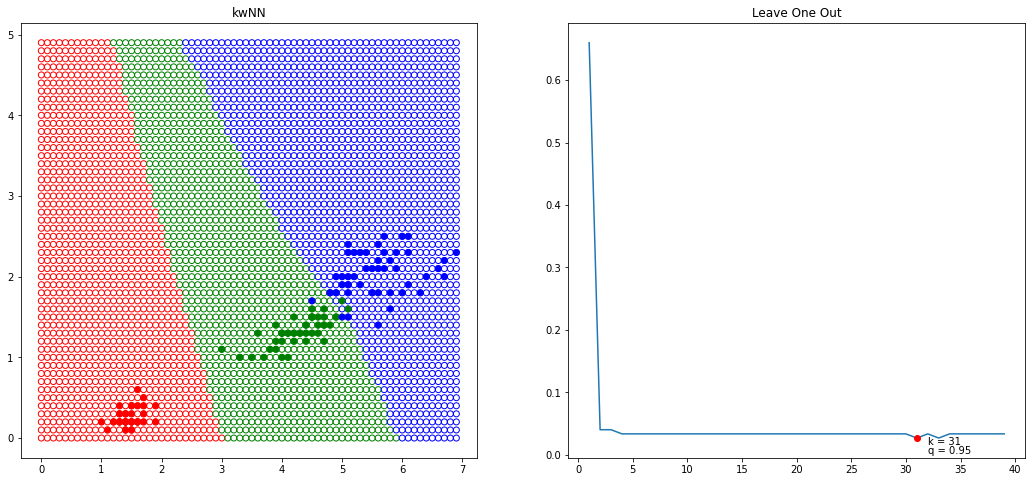

In [ ]:
def sortObjectByDistKwnn(point, data, target, k, q):
    distances = []
    for d in data:
        distances.append(euclide(point, d))
    res = list(zip(distances, target))
    sorted_by_distances = sorted(res, key=lambda dist: dist[0])
    class_weights = [0, 0, 0]
    for i in range(1, k):
        class_number = sorted_by_distances[i - 1][1]
        class_weights[class_number] += q ** i
    maxIndex = np.argmax(class_weights)
    return maxIndex


def LOOKwnn(data, target):
    k_limit = 40
    q_k_matrix = np.zeros((k_limit, 19))

    print()
    for q in range(19):
        q_norm = (5 + q * 5) / 100

        for k in range(1, k_limit):
            errors = []
            for i in range(150):
                error = 0
                dataCopy = list(data)
                objectData = dataCopy[i]
                dataCopy.pop(i)

                if sortObjectByDistKwnn(objectData, dataCopy, target, k, q_norm) != \
                        target[i]:
                    error += 1
                errors.append(error)
            q_k_matrix[k][q] = (sum(errors) - 1) / 150
            errors.clear()
    return q_k_matrix[1:]


def drawPointsKwnn(point, data, target, targetPoint, errors, k, q):
    cl = np.array(['red', 'green', 'blue'])
    fig = plt.figure(figsize=(18, 8))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    n_neighbors = np.array(range(1, len(errors) + 1))

    ax_1.set(title='kwNN')
    ax_1.scatter(point[:, 0], point[:, 1], edgecolors=cl[targetPoint],
                 facecolors='none')
    ax_1.scatter(data[:, 0], data[:, 1], color=cl[target])

    ax_2.set(title='Leave One Out')
    ax_2.scatter(k, errors[k - 1], color='red', zorder=1)
    ax_2.text(k + 1, errors[k - 1] - 0.01, f"k = {k}", fontsize=10)
    ax_2.text(k + 1, errors[k - 1] - 0.025, f"q = {q}", fontsize=10)
    ax_2.plot(n_neighbors, errors, zorder=0)

    plt.show()


def genPointsKwnn(data, target, k, q):
    k = int(k)
    point = []
    tr = []
    for i in range(70):
        v = i * 0.1
        for j in range(50):
            t = j * 0.1
            classPoint = sortObjectByDistKwnn(np.array([v, t]), data, target, k, q)
            point.append([v, t])
            tr.append(classPoint)
    return np.array(point), np.array(tr)


if __name__ == '__main__':
    errors_LOO = LOOKwnn(data, tr)

    min_ind = np.unravel_index(np.argmin(errors_LOO, axis=None), shape=(40, 19))
    k = min_ind[0] + 1
    q = (5 + min_ind[1] * 5) / 100

    point, targetPoint = genPointsKwnn(data, tr, k, q)

    drawPointsKwnn(point, data, tr, targetPoint, errors_LOO[:, min_ind[1]], k, q)


В результате работы мы получили, что наиболее оптимальными явлеются значения k = 31 и q = 0,95.

Достоинства алгоритма:

Простота реализации

1.   Простота реализации
2.   Хорошее качество, при правильно подобранной метрике и параметрах k и q

Недостатки алгоритма:

1.   Необходимость хранить выборку целиком, как следствие - неэффективное использование памяти
2.   Чрезмерное усложнение решающего правила
3.   Качество классификации сильно зависит от выбранной метрики
4.   Поиск ближайшего соседа предполагает сравнение классифицируемого объекта со всеми объектами выборки, что требует линейного по длине выборки числа операций.
